In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification # transformer package--to download the model from 
                                                                           # the HFwedsite
from scipy.special import softmax # scipy--used to convert the output of the model into probability scores
from wordcloud import WordCloud # plotting a WORD CLOUD plot(a visualization where the more specific word appears frequently)
import pandas as pd 
import numpy as np 
import re #regular expressions
import matplotlib.pyplot as plt # For plots
import seaborn as sns
from tqdm.notebook import tqdm # a progress bar tracker for doing some loops on the data

plt.style.use('ggplot')# Setting a styl sheet that will use for our plot

In [10]:
#Reading the data
tweets = pd.read_csv('tweetsSentimentAnalysis11.csv')
print(f"Total Length of the Dataset: {len(tweets)}")
tweets.head()

Total Length of the Dataset: 106


,Unnamed: 0.1,Unnamed: 0,position,title,snippet,sitelinks
0,0,0,0,The Information,2 days ago — Exclusive: Amazon and Snap reache...,NaN
1,1,1,1,InStyle,15 hours ago — 8 Amazon Products That Made My ...,NaN
2,2,2,2,Sylvia Varnham O'Regan,1 day ago — Scoop: Amazon has reached a deal w...,NaN
3,3,3,3,Glenn Gabe,1 day ago — Broadening Amazon's reach -> Amazo...,NaN
4,4,4,4,Roxxsaurus,"Feb 3, 2023 — 15 AMAZON PRODUCTS THAT WILL CHA...",NaN


In [11]:
# Clean the texts by creating a function to clean the tweets
# removal of the word and symbols by finding the patterns using regular expressions,
# and r to tell python that the expression is a RAW sring and substitude it with an empty string.
# We are simply doing some pre-processing on the text to make it appropriate for the way the model was trained
def cleanTxt(snippet):
    snippet = re.sub(r'@[A-Za-z0-9]+', '@user', snippet) # Replacing @ mentions with a string '@user'
    snippet = re.sub(r'https?:\/\/\S+', 'http', snippet) # converting the hyperlinks in to a string 'http'
    snippet = re.sub(r'#', '', snippet) # Removing the '#' symbol
    snippet = re.sub(r'Rt[\s]+', '', snippet) # Removing RT(retweets)
    snippet = re.sub(r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{1,2},\s\d{4}\s—\s', '', snippet) #Removing dates
    snippet = re.sub(r'^\s*\d+\s*(?:days?|hours?)\s*ago\s*,?\s*—\s', '', snippet)
    snippet = re.sub(r'\xa0...', '', snippet) # Removing the not extendd part
    
    return snippet

tweets['snippet'] = tweets['snippet'].apply(cleanTxt)# cleaning the text by applying the function
tweets['id'] = range(1, len(tweets) + 1)# adding an ID column

# Deleting unnecesary columns
tweets = tweets.drop(["position", "Unnamed: 0", "Unnamed: 0.1", "sitelinks"],
                    axis = 1)# To operate on columns  
tweets.head()# show the cleaned text

,title,snippet,id
0,The Information,Exclusive: Amazon and Snap reached a deal that...,1
1,InStyle,8 Amazon Products That Made My Life Easier Thi...,2
2,Sylvia Varnham O'Regan,Scoop: Amazon has reached a deal with Snap tha...,3
3,Glenn Gabe,Broadening Amazon's reach -> Amazon reaches a ...,4
4,Roxxsaurus,15 AMAZON PRODUCTS THAT WILL CHANGE YOUR LIFE....,5


In [12]:
# load the model and tokenizer [i.e. Downloading them] 

roberta = "cardiffnlp/twitter-roberta-base-sentiment" # copy the name of the model from HFweb
model = AutoModelForSequenceClassification.from_pretrained(roberta) # downloading the model from the website
tokenizer = AutoTokenizer.from_pretrained(roberta) # the tokenizer to convert our tweet text into appropriate numbers,
                                                   # so we can then pass the numbers into the model

In [13]:
example = tweets['snippet'][90]
print(example)

and me: Amazon has a deal with Snap that will let people buy Amazon products directly from ads without leaving Snapchat. Shows just how seriously Amazon is


In [14]:
# encoding the text as ones and zeros embeddings that the model will understand
encoded_text = tokenizer(example, return_tensors = 'pt')
encoded_text

{'input_ids': tensor([[    0,   463,   162,    35,  1645,    34,    10,   432,    19, 14100,
            14,    40,   905,    82,   907,  1645,   785,  2024,    31,  5814,
           396,  1618, 11477,     4, 28677,    95,   141,  3640,  1645,    16,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

In [15]:
output = model(**encoded_text)# Run the model on the encoded text and the output is the tensor
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.8601,  0.4431,  1.6888]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [16]:
scores = output[0][0].detach().numpy() # the output from tensors to numpy so that we can store this locally
scores

array([-1.8600566,  0.443097 ,  1.6888306], dtype=float32)

In [17]:
scores = softmax(scores) # Apply that softmax to the scores
scores

array([0.02184346, 0.21855885, 0.7595977 ], dtype=float32)

In [18]:
# dictionary to store the scores
scores_dict = {
    'Negative' : scores[0],
    'Neutral' : scores[1],
    'Positive' : scores[2]    
}
print(scores_dict)

{'Negative': 0.021843463, 'Neutral': 0.21855885, 'Positive': 0.7595977}


In [19]:
# Running the polarity score on the entire dataset 
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2]    
    }
    return scores_dict

In [20]:
# iterating over the dataset
res = {} # a dictionary to store this results
for i, row in tqdm(tweets.iterrows(), total = len(tweets)):
    text = row['snippet']
    myid = row['id']
    res[myid] = polarity_scores_roberta(text)    

  0%|          | 0/106 [00:01<?, ?it/s]

In [21]:
# storing this into a pandas dataframe
roberta = pd.DataFrame(res).T # and fliping everything horizontally
roberta = roberta.reset_index().rename(columns = {'index': 'id'})
roberta = roberta.merge(tweets, how = 'left')# To merge this results onto the original dataframe with a left medge

# Now we have sentiment score and metadata
roberta.head()

,id,Negative,Neutral,Positive,title,snippet
0,1,0.003809,0.217011,0.779180,The Information,Exclusive: Amazon and Snap reached a deal that...
1,2,0.001681,0.060062,0.938257,InStyle,8 Amazon Products That Made My Life Easier Thi...
2,3,0.004653,0.199511,0.795836,Sylvia Varnham O'Regan,Scoop: Amazon has reached a deal with Snap tha...
3,4,0.003806,0.252059,0.744135,Glenn Gabe,Broadening Amazon's reach -> Amazon reaches a ...
4,5,0.001875,0.111975,0.886150,Roxxsaurus,15 AMAZON PRODUCTS THAT WILL CHANGE YOUR LIFE....


In [22]:
# Specifying the columns to compare
columns_to_compare = ['Negative', 'Neutral', 'Positive']  

# Create a function to compute the negative, neutral, and positive analysis
def compute_selected_column(row):
    numeric_values = []
    
    for col in columns_to_compare:
        value = row[col]
        try:
            numeric_values.append(float(value))
        except (ValueError, TypeError):
            numeric_values.append(float('-inf'))  # Placeholder for non-numeric values
    
    selected_col_index = numeric_values.index(max(numeric_values))
    selected_col = columns_to_compare[selected_col_index]
    return selected_col

# Apply the function to each row
roberta['Analysis'] = roberta.apply(compute_selected_column, axis=1)# Creating a new column named Analysis
roberta.head()

,id,Negative,Neutral,Positive,title,snippet,Analysis
0,1,0.003809,0.217011,0.779180,The Information,Exclusive: Amazon and Snap reached a deal that...,Positive
1,2,0.001681,0.060062,0.938257,InStyle,8 Amazon Products That Made My Life Easier Thi...,Positive
2,3,0.004653,0.199511,0.795836,Sylvia Varnham O'Regan,Scoop: Amazon has reached a deal with Snap tha...,Positive
3,4,0.003806,0.252059,0.744135,Glenn Gabe,Broadening Amazon's reach -> Amazon reaches a ...,Positive
4,5,0.001875,0.111975,0.886150,Roxxsaurus,15 AMAZON PRODUCTS THAT WILL CHANGE YOUR LIFE....,Positive


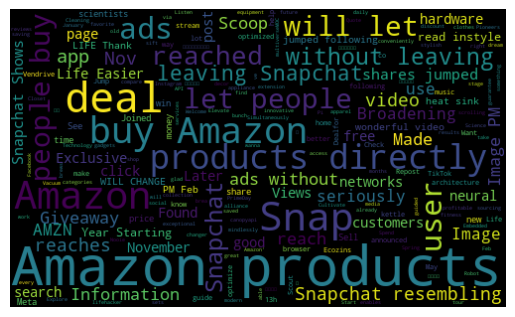

In [23]:
# Looking at how well the sentiment is distributed by understanding the common words,
# by plotting a WORD CLOUD plot(a visualization where the more specific word appears frequently) for each categories.
# Word cloud for positive sentiment
positive_data = roberta[roberta['Analysis'] == 'Positive']
positive_text = ' '.join( positive_data['snippet'] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(positive_text)

plt.imshow(wordCloud, interpolation = "bilinear")# Showing the wordCloud
plt.axis('off')# Removing the axis
plt.savefig('positive_text.png', dpi=300)# saving the figure
plt.show()# Showing the plot

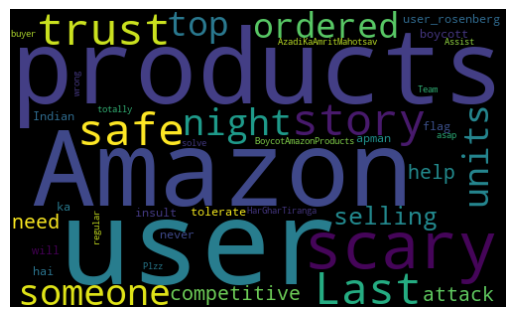

In [24]:
# Word cloud for negative sentiment
negative_data = roberta[roberta['Analysis'] == 'Negative']
negative_text = ' '.join( negative_data['snippet'] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(negative_text)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.savefig('negative_text.png', dpi=300)
plt.show()

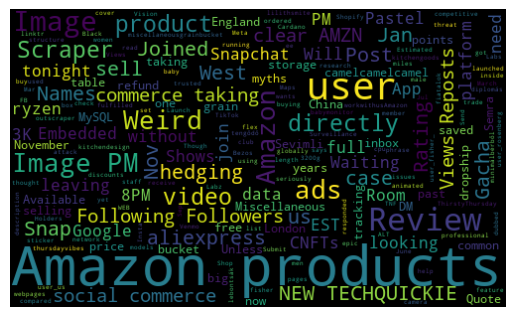

In [25]:
# Word cloud for neutral sentiment
neutral_data = roberta[roberta['Analysis'] == 'Neutral']
neutral_text = ' '.join( neutral_data['snippet'] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(neutral_text)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.savefig('neutral_text.png', dpi=300)
plt.show()

In [26]:
# Get the percentage of POSITIVE tweets
positive = roberta[roberta['Analysis']=="Positive"]# Get all of the data where analysis is Positive
pos = round(positive.shape[0]/roberta.shape[0]*100, 1)
print(str(pos)+"% of Positive tweets")

67.0% of Positive tweets


In [27]:
# Get the percentage of NEGATIVE tweets
negative = roberta[roberta['Analysis']=="Negative"]
neg = round(negative.shape[0]/roberta.shape[0]*100, 1)
print(str(neg)+"% of Negative tweets")

3.8% of Negative tweets


In [28]:
# Get the percentage of NEUTRAL tweets
neutral = roberta[roberta['Analysis']=="Neutral"]
neu = round(neutral.shape[0]/roberta.shape[0]*100, 1)
print(str(neu)+"% of Neutral tweets")

29.2% of Neutral tweets


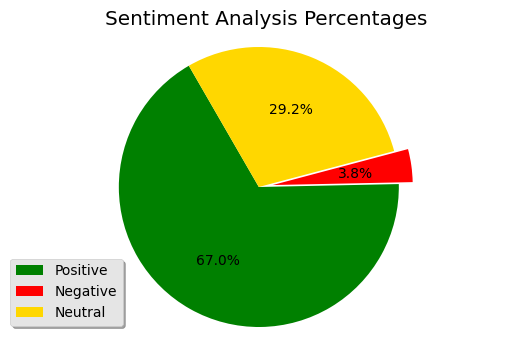

In [29]:
# Plot pie chart of the percentages
explode=(0,0.1,0)
labels='Positive', 'Negative', 'Neutral'
sizes=[pos,neg,neu]
colors=['green', 'red', 'gold']
plt.figure(figsize = (6,4))
plt.title('Sentiment Analysis Percentages')
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=120)
plt.legend(labels, loc=(-0.05,0.05), shadow=True)
plt.axis('equal')
plt.savefig('pie_chart.png', dpi=300)
plt.show()

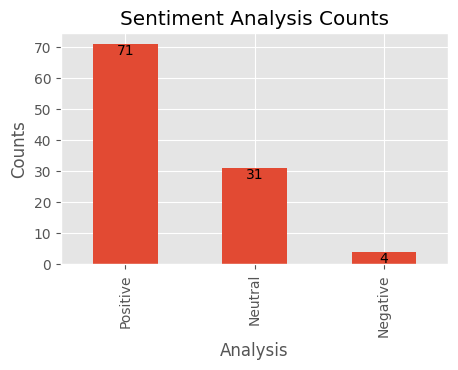

In [30]:
plt.figure(figsize = (5,3))
roberta['Analysis'].value_counts()# a Plot that show the value counts
# Plot and Visualize the counts
for i, value in enumerate(roberta['Analysis'].value_counts()):
    plt.text(i, value, str(value), ha='center', va='top')
plt.title('Sentiment Analysis Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
roberta['Analysis'].value_counts().plot(kind = 'bar')# Plot a bar graph
plt.show()